In [7]:
# plot cells and extract ephys features using ipfx

In [3]:
import pyabf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import glob

In [4]:
from scripts.util_functions import guess_response_gain, get_stim_gain, get_stim_info, get_stim_dict

In [5]:
# read final csv that has the ouput of metadata gathering process
csv_meta_save_path = 'output_files/cell_final_raw_meta_df.csv'
cell_final_raw_meta_df = pd.read_csv(open(csv_meta_save_path, 'rb'))  

In [6]:
from scripts.abf_plotting import plot_ephys_from_abf
from scripts.abf_to_sweep_set import cell_id_to_sweep_set
from scripts.abf_feature_extraction import get_baseball_card_fig, get_lsa_results

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1c239d2dd8>)

<Figure size 576x360 with 0 Axes>

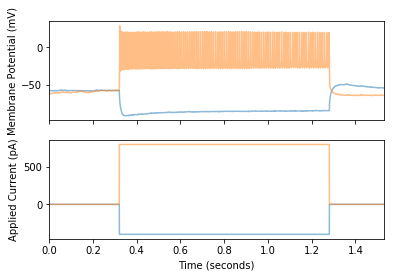

In [17]:
abf_file_name = "2015_11_09_0078.abf"
meta_row = cell_final_raw_meta_df.loc[cell_final_raw_meta_df['cell_id'] == abf_file_name]
num_sweeps = int(meta_row['num_sweeps'].values[0])
plot_ephys_from_abf(abf_file_name, cell_final_raw_meta_df, show_sweeps = [0, num_sweeps-1])

In [8]:
(sweep_set, start_time, end_time) = cell_id_to_sweep_set(abf_file_name, meta_info_df = cell_final_raw_meta_df)
sweep_set.sweeps[13].i[5000]
lsa_results = get_lsa_results(sweep_set, start_time, end_time)
summarize_cell_ephys_features(lsa_results)

NameError: name 'summarize_cell_ephys_features' is not defined

In [9]:
def summarize_cell_ephys_features(lsa_results):
    hero_keep_features = ['adapt', 'avg_rate', 'first_isi', 'isi_cv', 'latency', 'mean_isi', 'median_isi', 
                          'stim_amp']
    rheo_keep_features = ['threshold_v', 'peak_v', 'trough_v', 
     'fast_trough_v', 'adp_v', 'width', 'upstroke_downstroke_ratio']
    
    overall_cell_keep_features = ['v_baseline', 'rheobase_i', 'fi_fit_slope', 
                                  'sag', 'vm_for_sag', 'input_resistance', 'tau']
    
    hero_small_dict = lsa_results['hero_sweep'][hero_keep_features]
    rheobase_sweep_index = lsa_results['rheobase_sweep'].name
    rheobase_sweep = lsa_results['spikes_set'][rheobase_sweep_index].iloc[0]
    rheo_spike_small_dict = rheobase_sweep[rheo_keep_features]
    spike_comb_dict = {**hero_small_dict, **rheo_spike_small_dict}

    overall_cell_features = {x: lsa_results[x] for x in overall_cell_keep_features if x in lsa_results}
    final_cell_feature_dict = {**spike_comb_dict, **overall_cell_features}
    return(final_cell_feature_dict)

failing...
failing...


<Figure size 576x360 with 0 Axes>

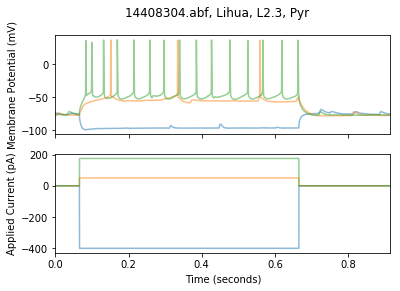

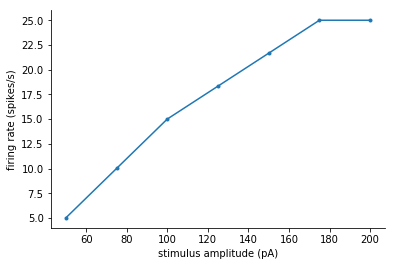

<Figure size 576x360 with 0 Axes>

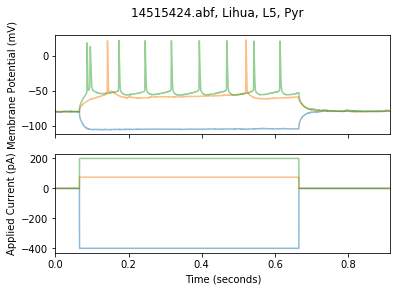

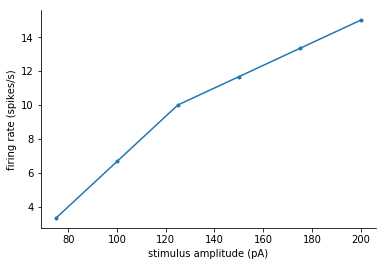

<Figure size 576x360 with 0 Axes>

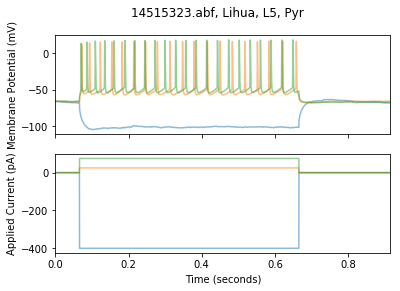

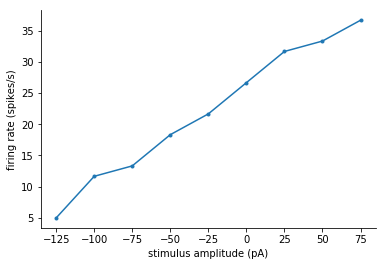

In [11]:
import warnings
warnings.filterwarnings('ignore')
from ipfx.error import FeatureError
import pickle
import pathlib

use_meta_df = cell_final_raw_meta_df.query('valid_stim == True')
cell_fail_list = list()
cell_feature_list = list()
update_existing = False
for abf_file_name in use_meta_df.cell_id:
    fn = "sweep_sets/" + abf_file_name + '.p'
    file = pathlib.Path(fn)
    abf_sweep_set_exists = file.exists()
    if abf_sweep_set_exists and update_existing:
        pass
    elif not abf_sweep_set_exists:
        pass
    else:
        continue
    try:
        (sweep_set, start_time, end_time) = cell_id_to_sweep_set(abf_file_name, meta_info_df = cell_final_raw_meta_df)
        lsa_results = get_lsa_results(sweep_set, start_time, end_time)
        get_baseball_card_fig(abf_file_name, lsa_results, meta_info_df = cell_final_raw_meta_df)
        curr_cell_features = summarize_cell_ephys_features(lsa_results)
        curr_cell_features['cell_id'] = abf_file_name
        cell_feature_list.append(curr_cell_features)
        fn = "sweep_sets/" + abf_file_name + '.p'
        pickle.dump( sweep_set, open( fn, "wb" ) )
        fn = "lsa_features/" + abf_file_name + '.p'
        pickle.dump( lsa_results, open( fn, "wb" ) )
    except (FeatureError) as e:
        cell_fail_list.append(abf_file_name)
        print('failing...')
        continue
    

In [13]:
cell_fail_list

['15127001.abf', '19128044.abf']

In [15]:
# go through lsa feature objects and load features and then write to csv
use_meta_df = cell_final_raw_meta_df.query('valid_stim == True')
cell_fail_list = list()
cell_feature_list = list()
update_existing = False
for abf_file_name in use_meta_df.cell_id:
    fn = "lsa_features/" + abf_file_name + '.p'
    file = pathlib.Path(fn)
    if file.exists():
        with open(fn, 'rb') as fp:
            lsa_results = pickle.load(fp)
            curr_cell_features = summarize_cell_ephys_features(lsa_results)
            curr_cell_features['cell_id'] = abf_file_name
            cell_feature_list.append(curr_cell_features)
extracted_cell_features = pd.DataFrame(cell_feature_list)
# save a final csv that has the ouput of this metadata gathering process
cell_features_csv_path = 'output_files/extracted_cell_features.csv'
extracted_cell_features.to_csv(cell_features_csv_path)

In [51]:
import pickle
fn = "sweep_sets/" + abf_file_name + '.p'
pickle.dump( sweep_set, open( fn, "wb" ) )

In [52]:
lsa_results.keys()

dict_keys(['spikes_set', 'sweeps', 'v_baseline', 'rheobase_i', 'rheobase_sweep', 'spiking_sweeps', 'fi_fit_slope', 'hero_sweep', 'sag', 'vm_for_sag', 'subthreshold_sweeps', 'subthreshold_membrane_property_sweeps', 'input_resistance', 'tau'])

In [53]:
rheobase_sweep_index = lsa_results['rheobase_sweep'].name
lsa_results['spikes_set'][rheobase_sweep_index].iloc[0]

threshold_index                   2711
clipped                          False
threshold_t                    0.13555
threshold_v                   -41.1072
threshold_i                        200
peak_index                        2735
peak_t                         0.13675
peak_v                         36.2244
peak_i                             200
trough_index                      2798
trough_t                        0.1399
trough_v                      -47.1802
trough_i                           200
upstroke_index                    2727
upstroke                       91.5076
upstroke_t                     0.13635
upstroke_v                    -20.2026
downstroke_index                  2748
downstroke                    -59.6988
downstroke_t                    0.1374
downstroke_v                 0.0915527
isi_type                        direct
fast_trough_index                 2793
fast_trough_t                  0.13965
fast_trough_v                 -46.9971
fast_trough_i            

In [54]:
lsa_results.keys()

dict_keys(['spikes_set', 'sweeps', 'v_baseline', 'rheobase_i', 'rheobase_sweep', 'spiking_sweeps', 'fi_fit_slope', 'hero_sweep', 'sag', 'vm_for_sag', 'subthreshold_sweeps', 'subthreshold_membrane_property_sweeps', 'input_resistance', 'tau'])

In [55]:
summarize_cell_ephys_features(lsa_results)

{'adapt': 0.1597471731526466,
 'avg_rate': 10.000833402783565,
 'first_isi': 0.028249999999999983,
 'isi_cv': 0.35928895444278125,
 'latency': 0.035750000000000004,
 'mean_isi': 0.09846,
 'median_isi': 0.11475000000000002,
 'stim_amp': 250.0,
 'threshold_v': -41.107178,
 'peak_v': 36.224365,
 'trough_v': -47.180176,
 'fast_trough_v': -46.99707,
 'adp_v': nan,
 'width': 0.0011000000000000176,
 'upstroke_downstroke_ratio': 1.5328217260441415,
 'v_baseline': -66.57853232489691,
 'rheobase_i': 200.0,
 'fi_fit_slope': 0.09905587370376108,
 'sag': 0.17223234474658966,
 'vm_for_sag': -89.72168,
 'input_resistance': 55.73817661830377,
 'tau': 0.010548226654707653}

In [41]:
lsa_results['spikes_set'][rheobase_sweep_index].iloc[0].keys()

Index(['threshold_index', 'clipped', 'threshold_t', 'threshold_v',
       'threshold_i', 'peak_index', 'peak_t', 'peak_v', 'peak_i',
       'trough_index', 'trough_t', 'trough_v', 'trough_i', 'upstroke_index',
       'upstroke', 'upstroke_t', 'upstroke_v', 'downstroke_index',
       'downstroke', 'downstroke_t', 'downstroke_v', 'isi_type',
       'fast_trough_index', 'fast_trough_t', 'fast_trough_v', 'fast_trough_i',
       'adp_index', 'adp_t', 'adp_v', 'adp_i', 'slow_trough_index',
       'slow_trough_t', 'slow_trough_v', 'slow_trough_i', 'width',
       'upstroke_downstroke_ratio'],
      dtype='object')

threshold_v                 -37.7408
peak_v                       53.0795
trough_v                    -43.4171
fast_trough_v               -41.0367
adp_v                            NaN
width                         0.0032
upstroke_downstroke_ratio    3.74452
Name: 0, dtype: object

In [73]:
cell_feature_dict = spike_comb_dict

In [74]:
cell_feature_dict

{'adapt': 0.2824815662344266,
 'avg_rate': 5.001667222407468,
 'first_isi': 0.1411,
 'isi_cv': 0.2824815662344266,
 'latency': 0.0431,
 'mean_isi': 0.19665,
 'median_isi': 0.19665,
 'stim_amp': 201.0,
 'threshold_v': -37.74082,
 'peak_v': 53.07949,
 'trough_v': -43.41709,
 'fast_trough_v': -41.03672,
 'adp_v': nan,
 'width': 0.0031999999999999806,
 'upstroke_downstroke_ratio': 3.7445235564151074}

In [76]:
subdict

{'v_baseline': -62.07230220121496,
 'rheobase_i': 151.0,
 'fi_fit_slope': 0.0325850709735251,
 'sag': 0.09917039424180984,
 'vm_for_sag': -90.53623,
 'input_resistance': 65.60883025900401,
 'tau': 0.017090597776175134}

In [80]:
final_cell_feature_list

{'adapt': 0.2824815662344266,
 'avg_rate': 5.001667222407468,
 'first_isi': 0.1411,
 'isi_cv': 0.2824815662344266,
 'latency': 0.0431,
 'mean_isi': 0.19665,
 'median_isi': 0.19665,
 'stim_amp': 201.0,
 'threshold_v': -37.74082,
 'peak_v': 53.07949,
 'trough_v': -43.41709,
 'fast_trough_v': -41.03672,
 'adp_v': nan,
 'width': 0.0031999999999999806,
 'upstroke_downstroke_ratio': 3.7445235564151074,
 'v_baseline': -62.07230220121496,
 'rheobase_i': 151.0,
 'fi_fit_slope': 0.0325850709735251,
 'sag': 0.09917039424180984,
 'vm_for_sag': -90.53623,
 'input_resistance': 65.60883025900401,
 'tau': 0.017090597776175134}